In [1]:
MAX_EPOCHS = 300
BATCH_SIZE = 128
SEQUENCE_LENGTH = 4
LEARNING_RATE = 0.001
SMILES_COL = 'Column3'
WAVELENGTH_COL = 'Column5'
URL = '/home/ishii/graduation_research/data/csvファイル/dft_B3LYP_6-31G*_zinc_for-sale_1000000_0to100000.csv'

In [2]:
#変更後のデータセット
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, wavelength_col):
        self.max_length = 0
        self.dummy_char = '_'
        
        self.url = url
        self.smiles_col = smiles_col
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

        self.wavelength_col = wavelength_col
        self.wavelengths = []
        self.items = self.generate_items()
        
        self.dummmy_index = self.word_to_index[self.dummy_char]

    def load_words(self):
        train_df = pd.read_csv(self.url, usecols=[SMILES_COL])
        self.smiles = list(train_df[self.smiles_col])
        for i, smile in enumerate(self.smiles):
            new_smile = smile[1:]
            self.smiles[i] = new_smile
        self.max_length = max(len(smile) for smile in self.smiles)
        self.smiles = list(smile.ljust(self.max_length, self.dummy_char) for smile in self.smiles)
        train_df = pd.Series(self.smiles)
        text = train_df.str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]
    
    def generate_items(self):
        train_df = pd.read_csv(self.url, usecols=[WAVELENGTH_COL])
        self.wavelengths = list(train_df[self.wavelength_col])
        items = []
        for i, smile in enumerate(self.smiles):
            smile = list(smile)
            items.append([self.word_to_index[w] for w in smile])
        return items

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.wavelengths)

    def __getitem__(self, index):
        return (
            torch.tensor(self.items[index]),
            torch.tensor(self.wavelengths[index])
        )

In [3]:
#変更後のモデル
import torch

class LSTM_Predictor(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Predictor, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            padding_idx=dataset.dummmy_index
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, 1)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [4]:
#変更後の訓練プロセス
import torch
import numpy as np

def train(dataset, model):
    losses = []
    val_losses = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(MAX_EPOCHS):
        model.train()
        
        state_h, state_c = model.init_state(BATCH_SIZE)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        total_loss = 0
        total_val_loss = 0

        for batch, (x, y) in enumerate(dataloader):
            if batch < int(len(dataloader) * 0.5):
                model.train()
                
                optimizer.zero_grad()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
                total_loss += loss.item()

                state_h = state_h.detach()
                state_c = state_c.detach()

                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                val_loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
                total_val_loss += val_loss.item()    
                
                state_h = state_h.detach()
                state_c = state_c.detach()
        
        
        print("Epoch: {}, train_Loss: {:.3f}, val_Loss: {:.3f}".format(
            epoch+1, 
            total_loss / int(len(dataloader) * 0.5),
            total_val_loss / (len(dataloader) - int(len(dataloader) * 0.5))
        ))
        losses.append(total_loss)
        val_losses.append(total_val_loss)
    return losses, val_losses

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = Dataset(url=URL, smiles_col=SMILES_COL, wavelength_col=WAVELENGTH_COL)
model = LSTM_Predictor(dataset)
model = model.to(device)
train_losses, val_losses = train(dataset, model)

Epoch: 1, train_Loss: 86367.353, val_Loss: 35401.977
Epoch: 2, train_Loss: 63739.394, val_Loss: 25787.017
Epoch: 3, train_Loss: 46477.512, val_Loss: 18356.633
Epoch: 4, train_Loss: 33102.944, val_Loss: 12620.126
Epoch: 5, train_Loss: 22962.693, val_Loss: 8442.311
Epoch: 6, train_Loss: 15675.919, val_Loss: 5510.346
Epoch: 7, train_Loss: 10631.547, val_Loss: 3555.710
Epoch: 8, train_Loss: 7328.264, val_Loss: 2341.646
Epoch: 9, train_Loss: 5318.250, val_Loss: 1656.343
Epoch: 10, train_Loss: 4206.511, val_Loss: 1317.385
Epoch: 11, train_Loss: 3663.283, val_Loss: 1179.466
Epoch: 12, train_Loss: 3437.899, val_Loss: 1140.069
Epoch: 13, train_Loss: 3363.645, val_Loss: 1138.189
Epoch: 14, train_Loss: 3347.436, val_Loss: 1145.074
Epoch: 15, train_Loss: 3347.558, val_Loss: 1151.194
Epoch: 16, train_Loss: 3349.924, val_Loss: 1155.283
Epoch: 17, train_Loss: 3351.516, val_Loss: 1158.199
Epoch: 18, train_Loss: 3352.350, val_Loss: 1160.710
Epoch: 19, train_Loss: 3352.807, val_Loss: 1163.137
Epoch: 20,

In [9]:
def predect(dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, drop_last=True)

    index = np.random.choice(len(test_dataloader))
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        smiles, wavelength = x, y
        if batch == 3:
            break
        
        state_h, state_c = model.init_state(5)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        y_pred, (state_h, state_c) = model(smiles.to(device), (state_h, state_c))
        y_pred_permute = torch.permute(y_pred, (2, 1, 0))    

        print(y_pred_permute)
        print(wavelength)
        print('\n')

In [10]:
predect(dataset, model)

tensor([[[ 52.3323,  52.3323,  79.5459,  79.5459,  79.5459],
         [115.7466, 115.7466, 193.1150, 201.4616, 201.4616],
         [153.4063, 153.4063, 328.7298, 254.2898, 254.2898],
         [172.7346, 172.7346, 359.6053, 268.9932, 272.4715],
         [202.7526, 202.7526, 366.0126, 249.1064, 274.9582],
         [211.9706, 211.9706, 348.5730, 245.3932, 271.0325],
         [215.9721, 219.5582, 320.9234, 256.6173, 266.1759],
         [234.5231, 224.4540, 296.8506, 261.2928, 267.6205],
         [241.9703, 231.0711, 279.5998, 261.0143, 281.7702],
         [241.4786, 231.3272, 242.4475, 253.6235, 288.7945],
         [252.6074, 243.4199, 203.1479, 256.2562, 285.8408],
         [258.4411, 253.3032, 195.4901, 253.1842, 275.0888],
         [271.0201, 267.4960, 217.4297, 249.4477, 266.3406],
         [279.9035, 270.2493, 220.4236, 246.5458, 252.3355],
         [279.2837, 267.7989, 237.5945, 245.6908, 245.0076],
         [274.8047, 262.0813, 241.6966, 244.7486, 243.1415],
         [265.0244, 248.

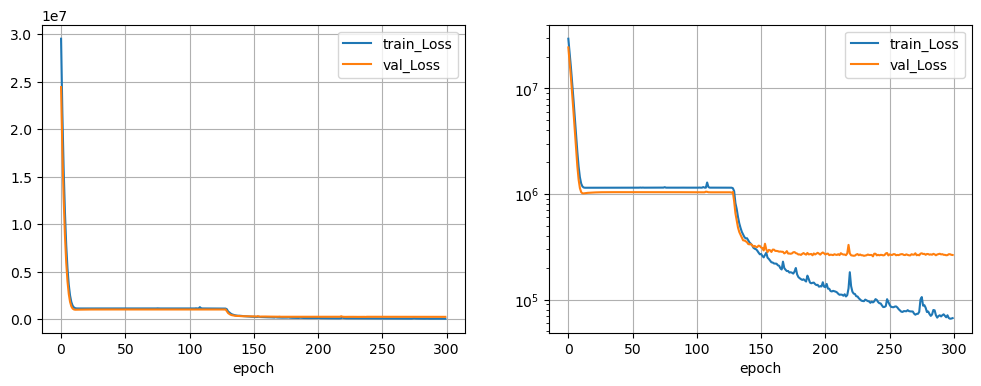

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses, label="train_Loss")
axes[0].plot(val_losses, label="val_Loss")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].legend()


axes[1].plot(train_losses, label="train_Loss")
axes[1].plot(val_losses, label="val_Loss")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].legend()

plt.show()